In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.models import LinearRegression
from src.loss import MSE
from src.optimizers.gd import GD
from src.regularizers import L1, L2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
X, y = make_regression(
    n_samples=500, n_features=100, n_informative=5, noise=20, random_state=42
)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 100), (400,), (100, 100), (100,))

In [17]:
from src.regularizers import Elastic_Net


steps = 2000
lr = 0.05

model_none = LinearRegression(loss=MSE(), opt=GD(lr=lr), steps=steps, reg=None)
model_l1 = LinearRegression(loss=MSE(), opt=GD(lr=lr), steps=steps, reg=L1(alpha=0.5))
model_l2 = LinearRegression(loss=MSE(), opt=GD(lr=lr), steps=steps, reg=L2(alpha=0.005))
model_en = LinearRegression(
    loss=MSE(), opt=GD(lr=lr), steps=steps, reg=Elastic_Net(alpha=0.05, l1_ratio=0.5)
)

model_none.fit(X_train, y_train)
model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)
model_en.fit(X_train, y_train)

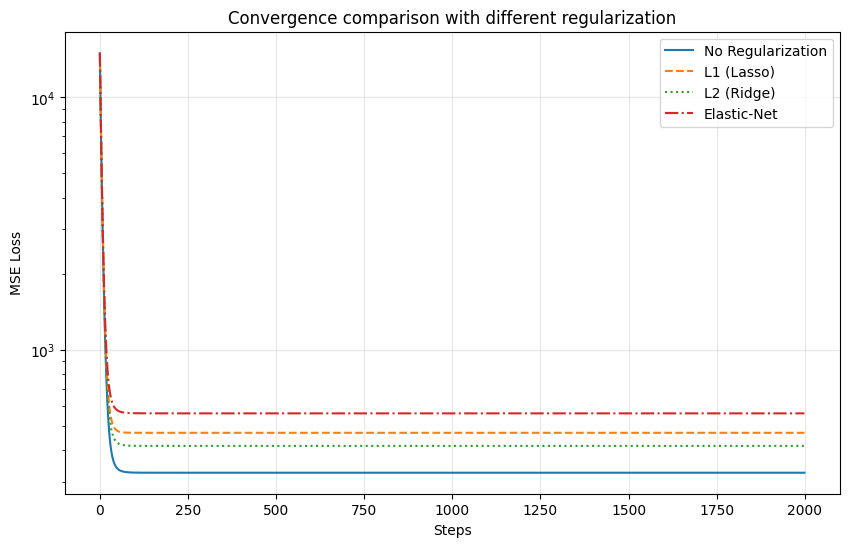

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(model_none.history, label="No Regularization", linestyle="solid")
plt.plot(model_l1.history, label="L1 (Lasso)", linestyle="dashed")
plt.plot(model_l2.history, label="L2 (Ridge)", linestyle="dotted")
plt.plot(model_en.history, label="Elastic-Net", linestyle="dashdot")

plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.title("Convergence comparison with different regularization")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale("log")
plt.show()

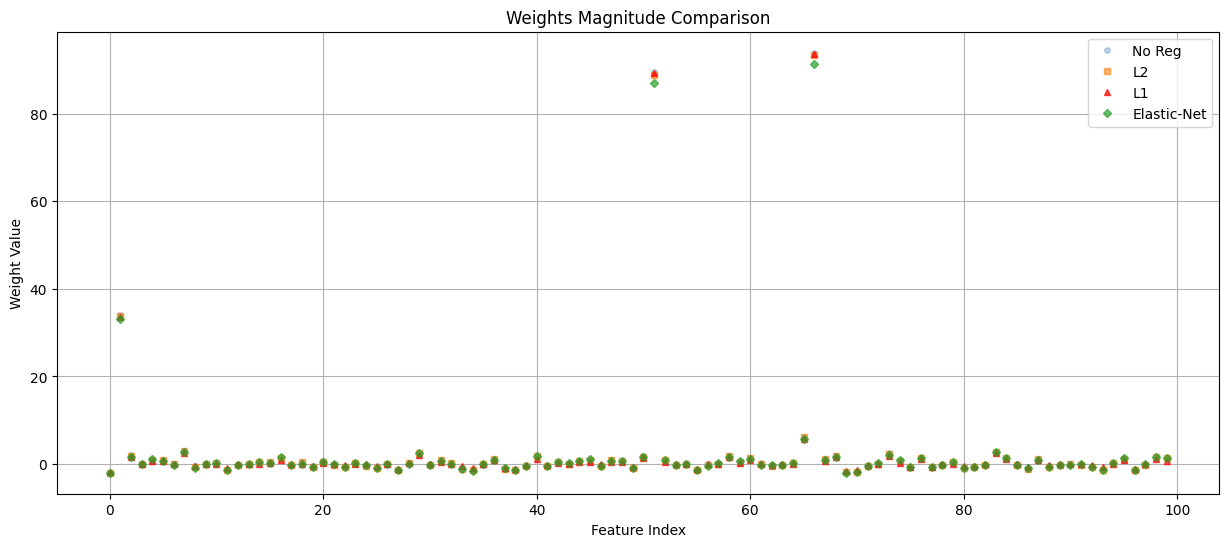

Zero weights in No Reg: 0
Zero weights in L2: 0
Zero weights in L1: 27
Zero weights in Elastic-Net: 1


In [19]:
plt.figure(figsize=(15, 6))

w_none = model_none.w[1:]
w_l1 = model_l1.w[1:]
w_l2 = model_l2.w[1:]
w_en = model_en.w[1:]

plt.plot(w_none, "o", label="No Reg", alpha=0.3, markersize=4)
plt.plot(w_l2, "s", label="L2", alpha=0.6, markersize=4)
plt.plot(w_l1, "^", label="L1", color="red", alpha=0.7, markersize=4)
plt.plot(w_en, "D", label="Elastic-Net", alpha=0.7, markersize=4)

plt.title("Weights Magnitude Comparison")
plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.show()

print(f"Zero weights in No Reg: {np.sum(np.abs(w_none) < 1e-4)}")
print(f"Zero weights in L2: {np.sum(np.abs(w_l2) < 1e-4)}")
print(f"Zero weights in L1: {np.sum(np.abs(w_l1) < 1e-4)}")
print(f"Zero weights in Elastic-Net: {np.sum(np.abs(w_en) < 1e-4)}")

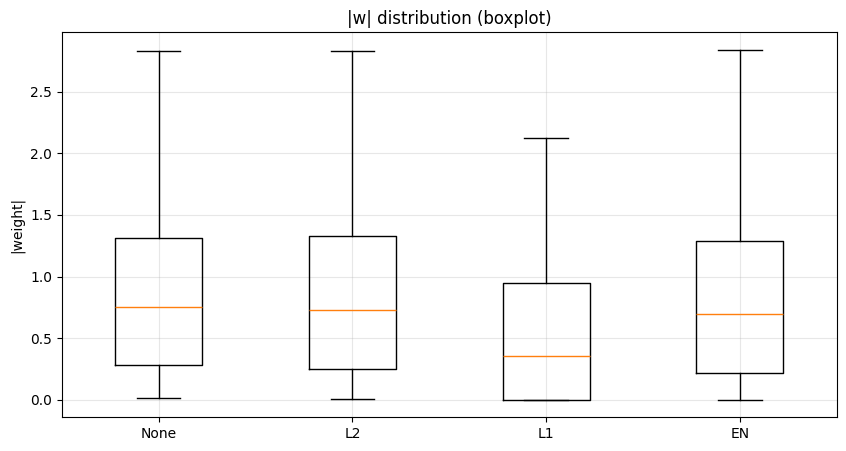

In [ ]:
weights = {
    "None": np.abs(model_none.w[1:]),
    "L2":   np.abs(model_l2.w[1:]),
    "L1":   np.abs(model_l1.w[1:]),
    "EN":   np.abs(model_en.w[1:]),
}

plt.figure(figsize=(10, 5))
plt.boxplot(list(weights.values()), tick_labels=list(weights.keys()), showfliers=False)
plt.title("|w| distribution (boxplot)")
plt.ylabel("|weight|")
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
y_pred_none = model_none.predict(X_test)
y_pred_l1 = model_l1.predict(X_test)
y_pred_l2 = model_l2.predict(X_test)
y_pred_en = model_en.predict(X_test)

print(f"None: {MSE()(y_test, y_pred_none)}")
print(f"L1 (Lasso): {MSE()(y_test, y_pred_l1)}")
print(f"L2 (Ridge): {MSE()(y_test, y_pred_l2)}")
print(f"Elastic-Net: {MSE()(y_test, y_pred_en)}")

None: 538.2754442254113
L1 (Lasso): 479.89780188592334
L2 (Ridge): 541.5650304269025
Elastic-Net: 563.8284579822649
